In [1]:
from sqlalchemy import create_engine, inspect, text
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import os
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

from data_processing._common.query_runner import QueryRunner

# define database connection
db_name = "urbanmining"
username = "postgres"
password = "Tunacompany5694!"
host = "localhost"  # or your host if it's not local
port = "5432"  # default port for PostgreSQL

connection_string = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)

In [2]:
query = ''' 
SELECT year, 
	SUM(emissions_operational_kg/1000) AS emissions_operational_kg, 
	SUM(emissions_embodied_kg/1000) AS emissions_embodied_kg
FROM new_housing_emissions 
GROUP BY year 
'''

df = pd.read_sql_query(query, engine)

fig = px.line(df, x='year', y=['emissions_operational_kg', 'emissions_embodied_kg'], 
              title='Emissions of new homes in NL', 
              labels={'value': 'Emissions (tons)', 'year': 'Year', 'variable': 'Emission type'})
fig.show()

fig = px.bar(df, x='year', y=['emissions_operational_kg', 'emissions_embodied_kg'], barmode='stack', 
             title='Emissions of new homes in NL', 
             labels={'value': 'Emissions (tons)', 'year': 'Year', 'variable': 'Emission type'})
fig.show()

In [3]:
with open('sql/new_housing/emissions_per_home.sql', 'r') as file:
    query = file.read()

df = pd.read_sql_query(text(query), engine)

In [4]:
av_operational = df.operational_per_sqm.mean()
av_embodied = df.embodied_per_sqm.mean()
def classify_municipality(row): 
    if row['operational_per_sqm'] > av_operational and row['embodied_per_sqm'] > av_embodied:
        return 'inefficient'
    elif row['operational_per_sqm'] > av_operational:
        return 'energy heavy'
    elif row['embodied_per_sqm'] > av_embodied:
        return 'material heavy'
    else:
        return 'efficient'
df['classification'] = df.apply(classify_municipality, axis=1)

In [5]:
# scatter plot of emissions per home in plotly express
color_dict = {
    'inefficient': '#636EFA', 
    'efficient': '#EF553B',
    'material heavy': '#AB63FA', 
    'energy heavy': '#00CC96'
}

fig = px.scatter(df, title='Emissions of new homes in NL per municipality', 
                 color='classification',
                 x='operational_per_sqm', y='embodied_per_sqm', 
                 hover_data=['municipality'], color_discrete_map=color_dict)
fig.update_layout(width=800)
fig.show()

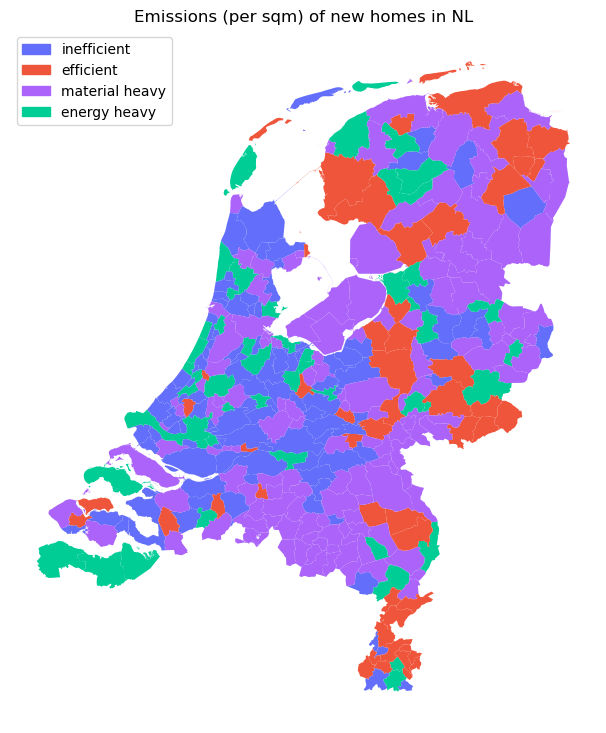

In [6]:
municipalities = gpd.read_postgis('SELECT geometry, "GM_NAAM" AS municipality FROM nl_gemeenten WHERE "AANT_INW" > 0', engine, geom_col='geometry')
df_map = municipalities.merge(df, on='municipality')

import matplotlib.patches as mpatches
df_map['color'] = df_map['classification'].map(color_dict)
fig, ax = plt.subplots(figsize=(15, 9))
df_map.plot(color=df_map['color'], legend=True, ax=ax, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.8, 1)})
ax.set_axis_off()
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_patches, loc='upper left')
ax.set_title('Emissions (per sqm) of new homes in NL')
plt.show()

In [84]:
df_map['p_operational'] = round(df_map['emissions_operational_kg'] / (df_map['emissions_operational_kg'] + df_map['emissions_embodied_kg']) * 100)
df_map['p_embodied'] = round(df_map['emissions_embodied_kg'] / (df_map['emissions_operational_kg'] + df_map['emissions_embodied_kg']) * 100)

df_long = df_map.melt(id_vars=["municipality", "classification"], 
                  value_vars=["p_operational", "p_embodied"],
                  var_name="emission_type", 
                  value_name="emission_value")

# Define the color scheme for operational and embodied
color_dict = {
    'p_operational': '#636EFA',  # Blue for operational
    'p_embodied': '#EF553B'      # Red for embodied
}

# Create a boxplot with Plotly Express
fig = px.box(df_long, 
             y="classification", 
             x="emission_value", 
             color="emission_type", 
             title="Operational vs Embodied Emissions per Classification",
             color_discrete_map=color_dict,
             labels={"emission_value": "Emissions (kg)", "classification": "Classification", "emission_type": "Emission Type"})

# Show the plot
fig.show()

In [99]:
query = ''' 
SELECT municipality, status, SUM(sqm) AS sqm
FROM new_housing_emissions 
WHERE status != 'in use'
GROUP BY municipality, status 
'''

sqm_byStatus = pd.read_sql_query(query, engine)
sqm_byStatus = sqm_byStatus.pivot_table(index='municipality', columns='status', values='sqm', aggfunc='sum').reset_index()
sqm_byStatus.columns = ['municipality', 'bouw_gestart', 'transformation']
sqm_byStatus['p_bouw_gestart'] = round(sqm_byStatus['bouw_gestart'] / (sqm_byStatus['bouw_gestart'] + sqm_byStatus['transformation']) * 100)
sqm_byStatus['p_transformation'] = round(sqm_byStatus['transformation'] / (sqm_byStatus['bouw_gestart'] + sqm_byStatus['transformation']) * 100)

sqm_byStatus = df[['municipality', 'classification']].merge(sqm_byStatus, on='municipality')
sqm_byStatus_long = sqm_byStatus.melt(id_vars=["municipality", "classification"], 
                  value_vars=["p_bouw_gestart", "p_transformation"],
                  var_name="status", 
                  value_name="sqm")
sqm_byStatus_long

fig = px.box(sqm_byStatus_long, 
             y="classification", 
             x="sqm", 
             color="status", 
             title="New vs Transformation Emissions per Classification",
             labels={"sqm": "sqm", "classification": "Classification", "status": "type"}, 
             category_orders={"classification": ["efficient", "inefficient", "energy heavy", "material heavy"]})
fig.show()